# Modeling


## Imports and Data Loading

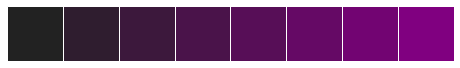

In [102]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sources_path = './../sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
import utils
from funk_svd.svd import SVD
from sklearn.model_selection import ShuffleSplit
    
data_dir = './../data'
plots_dir = './plots/'
progbar = utils.ProgressBar(elapsed_time=True)

palette = "purple"
second_palette = ["#60489D", "#46BB93", "#F9B74D"]
sns_palette = sns.dark_palette(palette, n_colors=8)
sns.palplot(sns_palette)
sns.set_palette(sns_palette)
sns.set(font_scale=1.2)

In [114]:
profile = pd.read_csv(os.path.join(data_dir, "profile.csv"), sep=';', parse_dates=["became_member_on"])
profile.set_index(["person"], inplace=True)
profile["days_since_subscription"] = (pd.Timestamp.today()-profile.became_member_on).dt.days
profile["gender_clean"] = profile.gender.map({"O": 0, "M": 1, "F": -1})
profile

,gender,age,became_member_on,income,days_since_subscription,gender_clean
person,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,1011,-1
78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,1078,-1
e2127556f4f64592b11af22de27a7932,M,68.0,2018-04-26,70000.0,726,1
389bc3fa690240e798340f5a15918d5c,M,65.0,2018-02-09,53000.0,802,1
2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,2017-11-11,51000.0,892,1
...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,2018-06-04,54000.0,687,-1
2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,2018-07-13,72000.0,648,1
01d26f638c274aa0b965d24cefe3183f,M,49.0,2017-01-26,73000.0,1181,1


In [2]:
df_matrix = pd.read_csv(os.path.join(data_dir, 'df_matrix.csv'), sep=';')#.set_index('person')
df_matrix.head()

,person,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
0,0009655768c64bdeb2e877511632db8f,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,8.0,5.0
1,0011e0d4e6b944f998e987f904e8c1e5,8.0,4.0,0.0,1.0,0.0,1.0,8.0,0.0,0.0,0.0
2,0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,0.0,11.0,1.0,0.0,1.0,0.0,5.0
3,0020ccbbb6d84e358d3414a3ff76cffd,0.0,6.0,0.0,0.0,0.0,1.0,8.0,0.0,8.0,0.0
4,003d66b6608740288d6cc97a6903f4f0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0


## SVD Training and Validation

In [3]:
df_ratings = pd.melt(df_matrix, id_vars='person').query("value != 0").reset_index(drop=True)
df_ratings.rename({"person": "u_id", "variable": "i_id", "value": "rating"}, axis=1, inplace=True)

### N Factors Sweep

In [15]:
%%time
n_folds = 5
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_n_factors = [20, 40, 60, 80, 100, 150, 200]
k = 3
threshold = 7

df_eval = pd.DataFrame(columns=["n_factors", "fold", 
                                "train_mae", "val_mae", "test_mae", 
                                "train_rmse", "val_rmse", "test_rmse",
                                "train_prec_at_"+str(k), "val_prec_at_"+str(k), "test_prec_at_"+str(k),
                                "train_recall_at_"+str(k), "val_recall_at_"+str(k), "test_recall_at_"+str(k)])

for n_factors in arr_n_factors:
    print ("Running analysis for {} factors".format(n_factors))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=n_factors, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            n_factors, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row

Running analysis for 20 factors
	Fold  0

Training took 0 sec


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 40 factors
	Fold  0

Training took 0 sec
	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 60 factors
	Fold  0

Training took 0 sec
	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 80 factors
	Fold  0

Training took 0 sec
	Fold  1

Training took 0 sec
	Fold  2

Training took 0 sec
	Fold  3

Training took 0 sec
	Fold  4

Training took 0 sec
Running analysis for 100 factors
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for 150 factors
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 se

Plotting results

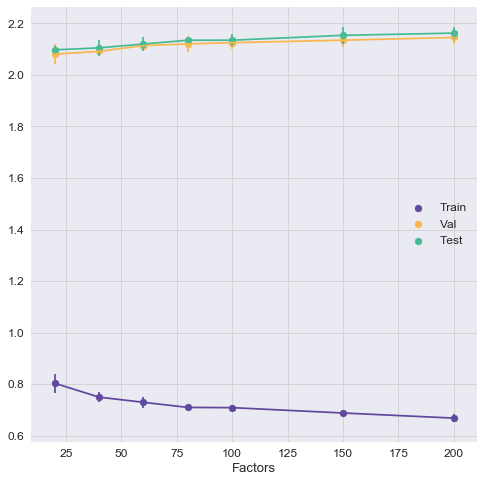

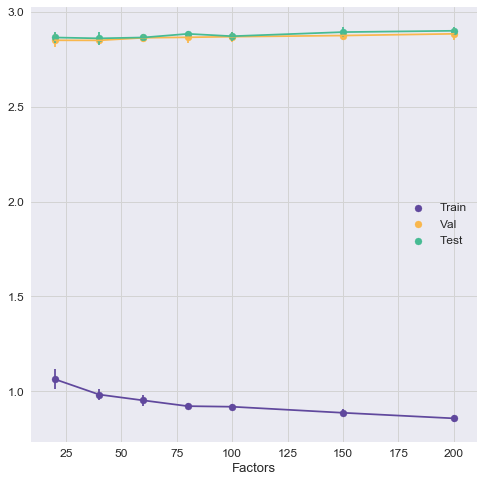

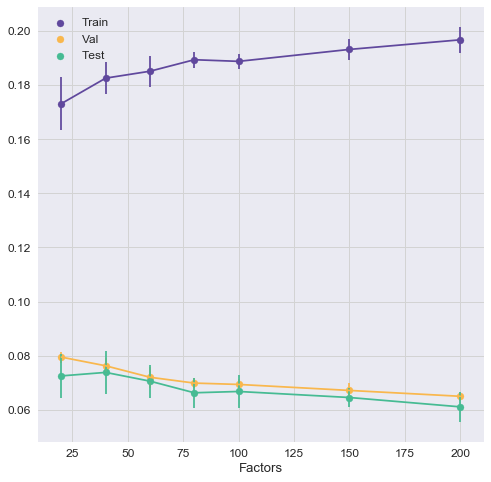

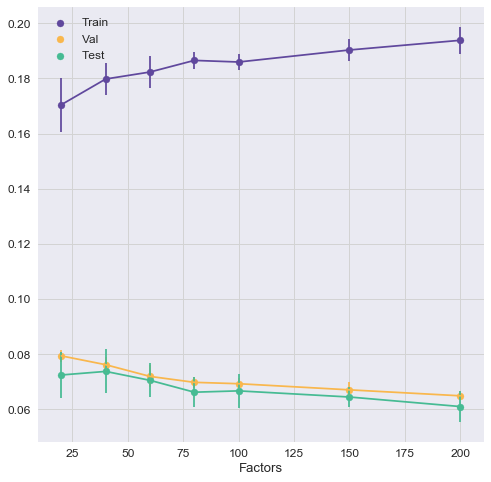

In [42]:
df_plot = df_eval.groupby(["n_factors"]).mean()
df_plot_std = df_eval.groupby(["n_factors"]).std()
# metric = 'mae'
for metric in ["mae", "rmse", "prec_at_" + str(k), "recall_at_" + str(k)]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i])
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Factors")
    ax.grid(True, color="lightgray")
    filename = "{}_factors_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

### Top K Sweep

In [47]:
df_matrix.drop(["person"], axis=1).shape[1]

10

In [48]:
%%time
n_folds = 5
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_k = np.arange(1, df_matrix.drop(["person"], axis=1).shape[1]+1, 1)
threshold = 7

df_eval = pd.DataFrame(columns=["k", "fold", 
                                "train_mae", "val_mae", "test_mae", 
                                "train_rmse", "val_rmse", "test_rmse",
                                "train_prec_at_k", "val_prec_at_k", "test_prec_at_k",
                                "train_recall_at_k", "val_recall_at_k", "test_recall_at_k"])

for k in arr_k:
    print ("Running analysis for k = {}".format(k))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=100, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            k, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row

Running analysis for k = 1
	Fold  0

Training took 1 sec


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 2
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 3
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 4
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 5
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1 sec
Running analysis for k = 6
	Fold  0

Training took 1 sec
	Fold  1

Training took 1 sec
	Fold  2

Training took 1 sec
	Fold  3

Training took 1 sec
	Fold  4

Training took 1

In [50]:
df_eval.head()

,k,fold,train_mae,val_mae,test_mae,train_rmse,val_rmse,test_rmse,train_prec_at_k,val_prec_at_k,test_prec_at_k,train_recall_at_k,val_recall_at_k,test_recall_at_k
0,1.0,0.0,0.679569,2.111600,2.154521,0.881040,2.859822,2.902461,0.361345,0.092115,0.063032,0.406544,0.092489,0.063080
1,1.0,1.0,0.686264,2.136793,2.168066,0.886127,2.873167,2.899599,0.357265,0.083922,0.069685,0.400986,0.083446,0.069373
2,1.0,2.0,0.713963,2.153825,2.094689,0.928242,2.907366,2.840564,0.342313,0.086391,0.064516,0.384733,0.087331,0.064592
3,1.0,3.0,0.715909,2.130265,2.132177,0.929970,2.870158,2.870631,0.344135,0.090420,0.078309,0.386362,0.090224,0.078370
4,1.0,4.0,0.679291,2.106456,2.145211,0.879235,2.847371,2.891555,0.358160,0.082323,0.067961,0.401253,0.082199,0.067961


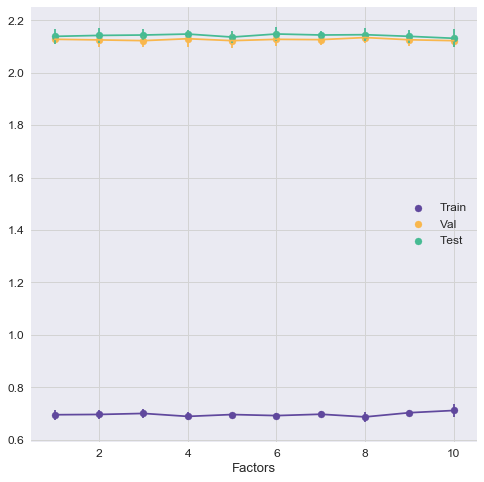

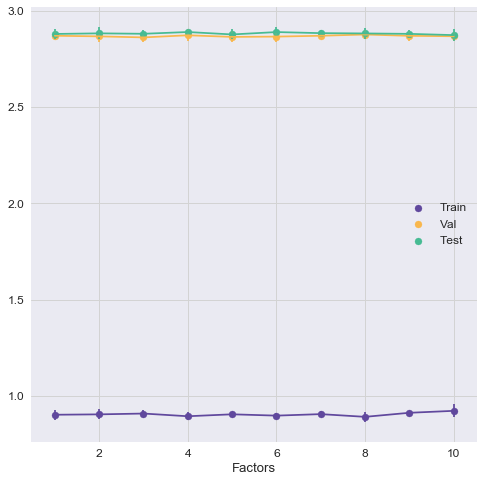

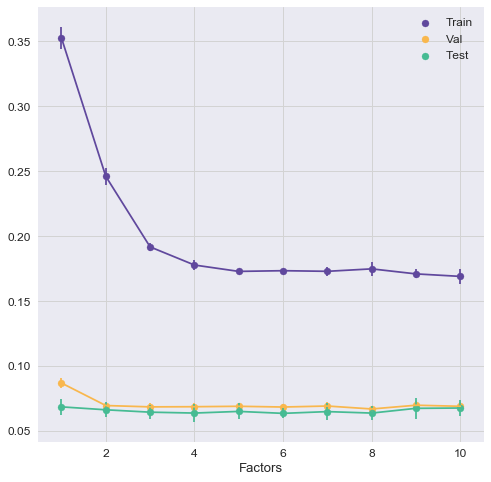

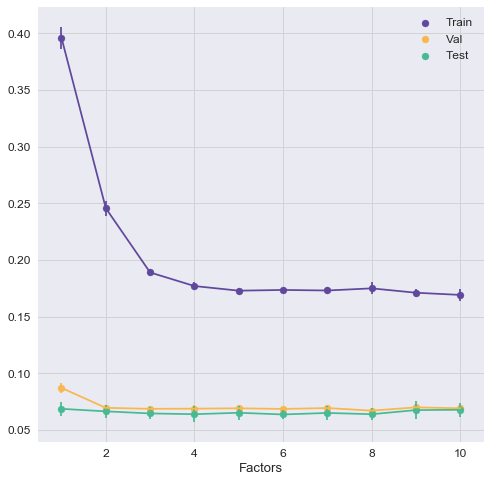

In [52]:

df_plot = df_eval.groupby(["k"]).mean()
df_plot_std = df_eval.groupby(["k"]).std()
# metric = 'mae'
for metric in ["mae", "rmse", "prec_at_k", "recall_at_k"]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i])
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Factors")
    ax.grid(True, color="lightgray")
    filename = "{}_top_k_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

In [59]:
df_matrix_original = svd.get_utility_matrix(df_ratings)

# Getting all u_id and i_id combinations
df_predictions= pd.melt(df_matrix_original.reset_index(drop=False), id_vars='u_id')
df_predictions.rename({"value": "rating"}, axis=1, inplace=True)

In [60]:
df_predictions["rating"] = svd.predict(df_user_item, clip=False)

In [63]:
df_matrix_predictions = svd.get_utility_matrix(df_predictions)
df_matrix_predictions

i_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
u_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5.243693,4.602773,3.601030,1.248209,8.091397,1.245518,5.318846,7.790100,4.658013,4.094152
0011e0d4e6b944f998e987f904e8c1e5,6.908468,5.444545,4.024990,1.298604,9.070723,1.301408,7.122838,8.104530,5.757983,4.704437
0020c2b971eb4e9188eac86d93036a77,4.592230,4.968443,3.190952,1.123211,10.077134,1.132384,4.237949,1.965343,4.722697,4.018721
0020ccbbb6d84e358d3414a3ff76cffd,4.270004,5.144302,3.743209,1.171232,7.942584,1.173379,5.804781,8.918973,6.913685,4.397454
003d66b6608740288d6cc97a6903f4f0,5.282039,4.399995,3.335268,1.212995,7.345489,1.211948,6.071861,7.676094,5.440792,4.169941
...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,4.602645,4.593273,3.512025,1.160009,6.850158,1.156383,5.730902,7.895240,4.336527,3.939646
fff7576017104bcc8677a8d63322b5e1,2.340957,3.042105,1.836320,1.198736,1.506204,1.200602,3.010847,1.481714,3.498382,2.759004
fff8957ea8b240a6b5e634b6ee8eafcf,4.139104,4.220657,3.015549,1.160584,6.250093,1.160107,4.837498,6.677259,4.733707,3.735336


## Clustering

In [67]:
df_matrix_predictions

i_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
u_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5.243693,4.602773,3.601030,1.248209,8.091397,1.245518,5.318846,7.790100,4.658013,4.094152
0011e0d4e6b944f998e987f904e8c1e5,6.908468,5.444545,4.024990,1.298604,9.070723,1.301408,7.122838,8.104530,5.757983,4.704437
0020c2b971eb4e9188eac86d93036a77,4.592230,4.968443,3.190952,1.123211,10.077134,1.132384,4.237949,1.965343,4.722697,4.018721
0020ccbbb6d84e358d3414a3ff76cffd,4.270004,5.144302,3.743209,1.171232,7.942584,1.173379,5.804781,8.918973,6.913685,4.397454
003d66b6608740288d6cc97a6903f4f0,5.282039,4.399995,3.335268,1.212995,7.345489,1.211948,6.071861,7.676094,5.440792,4.169941
...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,4.602645,4.593273,3.512025,1.160009,6.850158,1.156383,5.730902,7.895240,4.336527,3.939646
fff7576017104bcc8677a8d63322b5e1,2.340957,3.042105,1.836320,1.198736,1.506204,1.200602,3.010847,1.481714,3.498382,2.759004
fff8957ea8b240a6b5e634b6ee8eafcf,4.139104,4.220657,3.015549,1.160584,6.250093,1.160107,4.837498,6.677259,4.733707,3.735336


In [115]:


df_cluster = pd.merge(profile, df_matrix_predictions, how="inner", left_index=True, right_index=True)
df_cluster


,gender,age,became_member_on,income,days_since_subscription,gender_clean,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,1011,-1,4.256956,4.577503,3.267202,1.136812,8.314580,1.130662,5.765201,7.941382,5.570610,4.174282
78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,1078,-1,5.946281,5.366203,4.477595,1.198945,8.962851,1.194704,7.833948,12.345864,7.825267,5.057137
e2127556f4f64592b11af22de27a7932,M,68.0,2018-04-26,70000.0,726,1,4.310366,4.167399,2.768764,1.100516,4.944776,1.096535,4.955282,5.617094,5.635994,3.691165
389bc3fa690240e798340f5a15918d5c,M,65.0,2018-02-09,53000.0,802,1,4.411278,4.203346,3.127161,1.076760,6.118188,1.074214,4.176504,7.872630,5.030780,3.941954
2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,2017-11-11,51000.0,892,1,3.235521,3.439127,2.593819,1.121093,5.523298,1.123805,4.377201,6.283203,4.016128,3.456368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45.0,2018-06-04,54000.0,687,-1,2.613552,2.814873,2.115792,1.073663,1.292379,1.070375,3.022479,4.358787,2.906969,2.548869
2cb4f97358b841b9a9773a7aa05a9d77,M,61.0,2018-07-13,72000.0,648,1,3.661380,4.213738,2.816075,1.192478,5.150827,1.190025,4.322021,6.333796,4.037201,3.277267
01d26f638c274aa0b965d24cefe3183f,M,49.0,2017-01-26,73000.0,1181,1,1.728090,3.304599,2.262243,1.151849,5.124150,1.159344,3.230877,5.029228,4.260620,3.000535
9dc1421481194dcd9400aec7c9ae6366,F,83.0,2016-03-07,50000.0,1506,-1,7.653961,6.163237,4.579783,1.207592,12.438525,1.199854,7.521531,12.578690,7.349555,5.289600


In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [120]:

silhouette_avg = list()
arr_n_clusters = np.arange(2, 20, 1)
X = df_cluster.drop(["gender", "became_member_on", "days_since_subscription", "age", "gender_clean"], axis=1).values
df_silhouette_avg = pd.DataFrame(columns = ["fold", "n_cluster", "train_silhouette", "test_silhouette"])
trained_models = list()

for fold, [train_index, val_index] in enumerate(ss.split(X)):
    
    print ("Running analysis on fold {}".format(fold))
    X_train, X_val = X[train_index], X[val_index]
    
#     scaler = MinMaxScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    
    for n_cluster in arr_n_clusters:        
        model = KMeans(n_clusters=n_cluster, random_state=0)
        
        model.fit(X_train)
        train_silhouette = silhouette_score(X_train, model.predict(X_train))
        val_silhouette = silhouette_score(X_val, model.predict(X_val))

        row = [fold, n_cluster, train_silhouette, val_silhouette]
        df_silhouette_avg.loc[df_silhouette_avg.shape[0]] = row
    


Running analysis on fold 0
Running analysis on fold 1
Running analysis on fold 2
Running analysis on fold 3
Running analysis on fold 4


Text(0, 0.5, 'Silhouette Score')

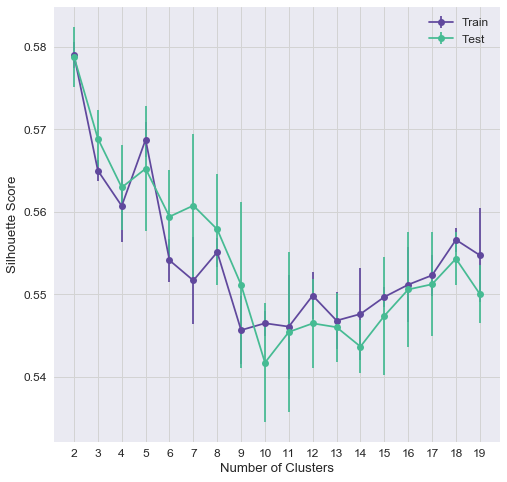

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
df_plot = df_silhouette_avg.groupby("n_cluster")
for i, set_label in enumerate(["train", "test"]):
    ax.errorbar(df_plot.mean().index, 
                df_plot.mean()[set_label + "_silhouette"].values, 
                df_plot.std()[set_label + "_silhouette"].values, label=set_label.title(),
               marker='o', mec='black', color = second_palette[i])
ax.set_xticks(arr_n_clusters), ax.set_xticklabels(arr_n_clusters)


ax.grid(True, color="lightgray")
ax.legend()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")

In [109]:
n_clusters = 5

In [110]:
model = KMeans(n_clusters=n_clusters, random_state=0)        
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
model.